Classification in GPflow
--

*Alexander G. de G. Matthews and James Hensman 2016*

This script replicates 

Hensman, Matthews, Ghahramani, AISTATS 2015, Scalable Variational Gaussian Process Classification, Figure 1 Row 1.

It serves to demonstrate sparse variational GP classification on a simple, easily visualized dataset.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import csv
import numpy as np
import gpflow
import tensorflow as tf

/Users/jmxp/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
Xtrain = np.loadtxt('data/banana_X_train', delimiter=',')
Ytrain = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)


In [3]:
def gridParams():
    mins = [-3.25,-2.85 ] 
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot
     
def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'feat') and hasattr(m.feat, 'Z'):
        Z = m.feature.Z.read_value()
        ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
        ax.set_title('m={}'.format(Z.shape[0]))
    else:
        ax.set_title('full')
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)
    


In [4]:
models = []

In [5]:
global_step = tf.get_variable("global_step", (), tf.int32, tf.zeros_initializer(), trainable=False)
learning_rate = 0.1
k = 0.5
learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, 1, k)

In [6]:
# Run variational approximation without sparsity..
# ..be aware that this is much slower for big datasets,
# but relatively quick here.
m = gpflow.models.VGP(Xtrain, Ytrain,
                      kern=gpflow.kernels.RBF(2),
                      likelihood=gpflow.likelihoods.Bernoulli())

In [7]:
tf.summary.scalar("ELBO", m.likelihood_tensor)
tf.summary.scalar("learning_rate", learning_rate)
log_op = tf.summary.merge_all()
logfile = tf.summary.FileWriter("test_run")

In [8]:
gpflow.train.AdamOptimizer(learning_rate).minimize(m, maxiter=2000, 
                                                   var_list=[global_step], global_step=global_step,
                                                   summary_op=log_op, file_writer=logfile)
models.append(m)

/Users/jmxp/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/jmxp/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


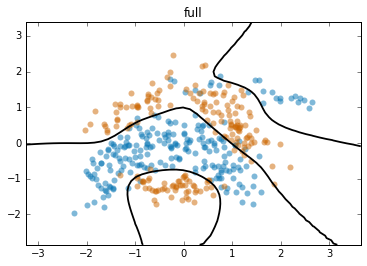

In [10]:
plot(m, plt.gca())